### Chain Using LangGraph
Let us see how can we build a simple chain using Langgraph that uses 4 important concepts:

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes

In [17]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, HumanMessage, AnyMessage
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages ## used for adding messages to the list in state

# use this to import tool_condition and ToolNode
from langgraph.prebuilt import ToolNode, tools_condition

from typing import Annotated
from pydantic import BaseModel
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# Initialize Groq model using init_chat_model (newer way of setting up models in langchain)
model = init_chat_model(
    model="llama-3.1-8b-instant",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

In [3]:
model.invoke("Hello")

AIMessage(content='Hello. What can I help you with today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 36, 'total_tokens': 47, 'completion_time': 0.014334971, 'completion_tokens_details': None, 'prompt_time': 0.001973081, 'prompt_tokens_details': None, 'queue_time': 0.005769237, 'total_time': 0.016308052}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9ca2574dca', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--83a2df06-0b69-4087-82ba-6168494cd733-0', usage_metadata={'input_tokens': 36, 'output_tokens': 11, 'total_tokens': 47})

#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
All these Messages are inherited by BaseMessage, there is also AnyMessage we can use.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

In [4]:
messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Srini"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Srini"))

for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Srini

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Srini

I want to learn python programming language


In [5]:
response = model.invoke(messages)

In [6]:
response.response_metadata

{'token_usage': {'completion_tokens': 549,
  'prompt_tokens': 76,
  'total_tokens': 625,
  'completion_time': 0.654957203,
  'completion_tokens_details': None,
  'prompt_time': 0.004352878,
  'prompt_tokens_details': None,
  'queue_time': 0.005191936,
  'total_time': 0.659310081},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_9ca2574dca',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

In [7]:
response.content

"Python is a great language to learn, especially for beginners. It's known for its simplicity, readability, and versatility. Here's a step-by-step guide to help you get started with Python programming:\n\n**Step 1: Set up your environment**\n\n1. Install Python on your computer. You can download the latest version from the official Python website: <https://www.python.org/downloads/>\n2. Choose a code editor or IDE (Integrated Development Environment) to write and run your Python code. Some popular choices include:\n\t* PyCharm\n\t* Visual Studio Code (VS Code)\n\t* Sublime Text\n\t* Atom\n3. Familiarize yourself with the basic syntax and data types in Python.\n\n**Step 2: Learn the basics**\n\n1. Start with basic data types: numbers, strings, booleans, lists, dictionaries, and sets.\n2. Learn about variables, operators, and control structures (if-else statements, loops, etc.).\n3. Understand functions and modules in Python.\n\n**Step 3: Practice and build projects**\n\n1. Start with si

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

Because LLM does not have all the capabilities, tools help augment the information.

In [8]:
@tool
def add_two_numbers(a: int, b: int) -> int:
    """Add two numbers given two inputs."""
    return a + b

In [9]:
# bind the model with tools
tools = [add_two_numbers]
model_with_tools = model.bind_tools(tools)

In [10]:
model_with_tools.invoke("What is 2 plus 2")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7rd13d7mm', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add_two_numbers'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 229, 'total_tokens': 249, 'completion_time': 0.030900653, 'completion_tokens_details': None, 'prompt_time': 0.015139477, 'prompt_tokens_details': None, 'queue_time': 0.005192109, 'total_time': 0.04604013}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4dea31877a', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--148b2836-6a79-4007-9262-3102a7ae98c8-0', tool_calls=[{'name': 'add_two_numbers', 'args': {'a': 2, 'b': 2}, 'id': '7rd13d7mm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 229, 'output_tokens': 20, 'total_tokens': 249})

In [11]:
# let us build the State

class ChatState(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [12]:
# let us implement the chat node
def chat_node(state: ChatState) -> ChatState:
    response = model_with_tools.invoke(state.messages)
    state.messages = state.messages + [response]
    return state

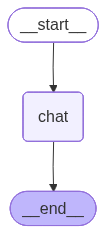

In [13]:
# now lets build a graph

# initialize the graph
graph = StateGraph(ChatState)

# add nodes
graph.add_node("chat", chat_node)

# add edges
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

# compile the graph
workflow = graph.compile()
workflow


In [14]:
# lets run the workflow
initial_state = {'messages': [HumanMessage(content="Hello")]}
final_state = workflow.invoke(initial_state)

final_state

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='8416f654-645c-4e3c-aa9f-feaf3e211bbc'),
  AIMessage(content="I'm happy to chat with you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 223, 'total_tokens': 239, 'completion_time': 0.027588332, 'completion_tokens_details': None, 'prompt_time': 0.014990638, 'prompt_tokens_details': None, 'queue_time': 0.00524554, 'total_time': 0.04257897}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4dea31877a', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--054e1ea0-dc1b-47b0-83f4-2191a4269a9d-0', usage_metadata={'input_tokens': 223, 'output_tokens': 16, 'total_tokens': 239})]}

In [15]:
final_state['messages'].append(HumanMessage(content="Can you add 2 and 2? "))

new_initial_state = final_state
new_initial_state

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='8416f654-645c-4e3c-aa9f-feaf3e211bbc'),
  AIMessage(content="I'm happy to chat with you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 223, 'total_tokens': 239, 'completion_time': 0.027588332, 'completion_tokens_details': None, 'prompt_time': 0.014990638, 'prompt_tokens_details': None, 'queue_time': 0.00524554, 'total_time': 0.04257897}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4dea31877a', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--054e1ea0-dc1b-47b0-83f4-2191a4269a9d-0', usage_metadata={'input_tokens': 223, 'output_tokens': 16, 'total_tokens': 239}),
  HumanMessage(content='Can you add 2 and 2? ', additional_kwargs={}, response_metadata={})]}

In [16]:
new_final_state = workflow.invoke(new_initial_state)
new_final_state

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='8416f654-645c-4e3c-aa9f-feaf3e211bbc'),
  AIMessage(content="I'm happy to chat with you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 223, 'total_tokens': 239, 'completion_time': 0.027588332, 'completion_tokens_details': None, 'prompt_time': 0.014990638, 'prompt_tokens_details': None, 'queue_time': 0.00524554, 'total_time': 0.04257897}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4dea31877a', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--054e1ea0-dc1b-47b0-83f4-2191a4269a9d-0', usage_metadata={'input_tokens': 223, 'output_tokens': 16, 'total_tokens': 239}),
  HumanMessage(content='Can you add 2 and 2? ', additional_kwargs={}, response_metadata={}, id='7b40251e-eccc-421e-87d2-d79dd75a6d29'),
  AIMessage(content='', additional_kwar

How to call the tool, when we receive an output from LLM that we need to call tool ?

Here are the steps:
- create a node called tool node => `tools_node = ToolNode(tools)` 
- add the tool_node to the graph => `graph.add_node("tools", tools_node)`
- create appropriate edges
    ```
    graph.add_edge(START, "chat")
    graph.add_conditional_edges("chat", tools_condition)
    graph.add_edge("tools", "chat")
    graph.add_edge("chat", END)
    ```
- finally compile and invoke the work flow

In [19]:
tools_node = ToolNode(tools)

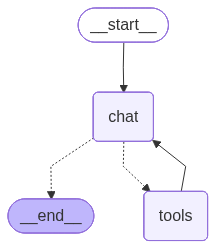

In [22]:
# now lets build a graph with tools

# initialize the graph
graph = StateGraph(ChatState)

# add nodes
graph.add_node("chat", chat_node)
graph.add_node("tools", tools_node)

# add edges
graph.add_edge(START, "chat")
graph.add_conditional_edges("chat", tools_condition)
graph.add_edge("tools", "chat")
graph.add_edge("chat", END)

# compile the graph
workflow_with_tools = graph.compile()
workflow_with_tools

In [23]:
initial_state = {'messages': [HumanMessage(content="Hello")]}
final_state = workflow_with_tools.invoke(initial_state)
final_state

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='69abffd2-7501-4916-a5e1-8a72f81ec72d'),
  AIMessage(content="I'm happy to chat with you. Is there something I can help you with or would you like to know more about the functions I have access to?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 223, 'total_tokens': 255, 'completion_time': 0.051886039, 'completion_tokens_details': None, 'prompt_time': 0.015315312, 'prompt_tokens_details': None, 'queue_time': 0.006998855, 'total_time': 0.067201351}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9ca2574dca', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--668e5399-03a3-4c4b-a9d9-39ce700361df-0', usage_metadata={'input_tokens': 223, 'output_tokens': 32, 'total_tokens': 255})]}

In [24]:
final_state['messages'].append(HumanMessage(content="Can you add 2 and 2? "))
new_initial_state = final_state
new_final_state = workflow_with_tools.invoke(new_initial_state)
new_final_state

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='69abffd2-7501-4916-a5e1-8a72f81ec72d'),
  AIMessage(content="I'm happy to chat with you. Is there something I can help you with or would you like to know more about the functions I have access to?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 223, 'total_tokens': 255, 'completion_time': 0.051886039, 'completion_tokens_details': None, 'prompt_time': 0.015315312, 'prompt_tokens_details': None, 'queue_time': 0.006998855, 'total_time': 0.067201351}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9ca2574dca', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--668e5399-03a3-4c4b-a9d9-39ce700361df-0', usage_metadata={'input_tokens': 223, 'output_tokens': 32, 'total_tokens': 255}),
  HumanMessage(content='Can you add 2 and 2? ', additional_kwargs={}, response_metadata={}, i

In [25]:
for message in new_final_state['messages']:
    message.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

I'm happy to chat with you. Is there something I can help you with or would you like to know more about the functions I have access to?
================================ Human Message =================================

Can you add 2 and 2? 
================================== Ai Message ==================================
Tool Calls:
  add_two_numbers (4qzm06cqb)
 Call ID: 4qzm06cqb
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add_two_numbers

4
================================== Ai Message ==================================

The result of the function call is 4.
